Error with C:/Users/andre/Desktop/UrbanMining/SortedMaterials\glass\086_00411_knock_07.wav: when mode='interp', width=9 cannot exceed data.shape[axis]=6
Error with C:/Users/andre/Desktop/UrbanMining/SortedMaterials\metal\052_01211_knock_07.wav: when mode='interp', width=9 cannot exceed data.shape[axis]=5
Error with C:/Users/andre/Desktop/UrbanMining/SortedMaterials\metal\073_00211_knock_07.wav: when mode='interp', width=9 cannot exceed data.shape[axis]=5

FOLD 1
Test Accuracy: 64.41%
Train Accuracy: 98.51%

FOLD 2
Test Accuracy: 60.50%
Train Accuracy: 99.36%

FOLD 3
Test Accuracy: 69.23%
Train Accuracy: 99.36%

FOLD 4
Test Accuracy: 75.21%
Train Accuracy: 99.58%

FOLD 5
Test Accuracy: 65.81%
Train Accuracy: 99.36%


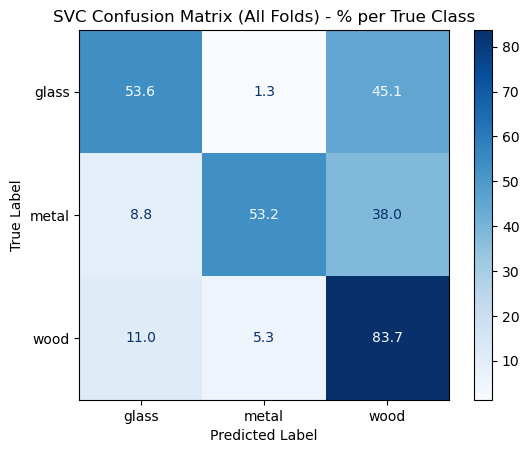

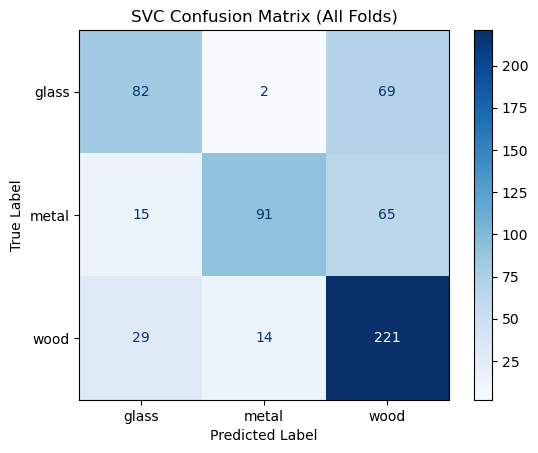


Mean CV Accuracy: 67.03%

Mean CV Accuracy: 67.03%


In [ ]:

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
import re

# Define Paths
base_dir = r"C:/Users/andre/Desktop/UrbanMining/SortedMaterials"
sr = 22050  # sample rate


#  Feature Extraction Function
def extract_features(file_path):
    y, _ = librosa.load(file_path, sr=sr)
    y = y.astype(np.float32)

    # MFCCs and their deltas
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    # Spectral features
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    onset = librosa.onset.onset_strength(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    rms = librosa.feature.rms(y=y)

    # Aggregate features
    features = np.hstack([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(mfcc_delta, axis=1), np.std(mfcc_delta, axis=1),
        np.mean(mfcc_delta2, axis=1), np.std(mfcc_delta2, axis=1),
        np.mean(centroid), np.std(centroid),
        np.mean(bandwidth), np.std(bandwidth),
        np.mean(onset), np.std(onset),
        np.mean(zcr), np.std(zcr),
        np.mean(rms), np.std(rms),
        np.mean(contrast, axis=1), np.std(contrast, axis=1)
    ])

    return features


# Load Data
X, y, groups = [], [], []
door_to_group = {}
group_counter = 0

for label in ["glass", "metal", "wood"]:
    path = os.path.join(base_dir, label)
    for wav_file in glob(os.path.join(path, "*.wav")):
        try:
            features = extract_features(wav_file)
            X.append(features)
            y.append(label)

            fname = os.path.basename(wav_file)
            match = re.match(r'^(\d+_\d+)', fname)
            if not match:
                raise ValueError(f"Could not extract door ID from: {fname}")
            door_id = match.group(1)

            if door_id not in door_to_group:
                door_to_group[door_id] = group_counter
                group_counter += 1

            groups.append(door_to_group[door_id])
        except Exception as e:
            print(f"Error with {wav_file}: {e}")

X = np.array(X)
y = np.array(y)
groups = np.array(groups)

# GroupKFold Cross-Validation with All Fold Predictions Stored
gkf = GroupKFold(n_splits=5)
fold = 1
accuracies = []

all_y_test = []
all_y_pred = []

for train_idx, test_idx in gkf.split(X, y, groups):
    print(f"\nFOLD {fold}")
    fold += 1

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test_fold = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = SVC(kernel='rbf', C=1, gamma='auto', random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred_fold = model.predict(X_test)

    acc = accuracy_score(y_test_fold, y_pred_fold)
    train_acc = model.score(X_train, y_train)
    print(f"Test Accuracy: {acc * 100:.2f}%")
    print(f"Train Accuracy: {train_acc * 100:.2f}%")
    accuracies.append(acc)

    all_y_test.extend(y_test_fold)
    all_y_pred.extend(y_pred_fold)

# Aggregate Confusion Matrices
labels_order = ["glass", "metal", "wood"]
cm = confusion_matrix(all_y_test, all_y_pred, labels=labels_order)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot percentage confusion matrix
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=labels_order)
disp.plot(cmap='Blues', values_format=".1f", ax=ax)
plt.title("SVC Confusion Matrix (All Folds) - % per True Class")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Plot raw confusion matrix
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
disp.plot(cmap='Blues', values_format="d", ax=ax)
plt.title("SVC Confusion Matrix (All Folds)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Print Mean Accuracy
print(f"\nMean CV Accuracy: {np.mean(accuracies) * 100:.2f}%")



